In [2]:
#!pip install pandas
#!pip install matplotlib
#!pip install numpy

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# The energy situation in Italy: an overview


In June 2023, Italy's "Integrated National Plan for Energy and Climate" (PNIEC) has been released by the Italian government, setting new goals for the evolution of the energy sector in the country for the next decade. The strategy presented in the plan is organized according to five closely interconnected dimensions:
- energy sustainability and decarbonization;
- energy efficiency;
- energy security;
- internal energy market;
- research, innovation and competitiveness.

This work mainly focuses on the sustainability and security dimensions. Some visual representation of the considered data is provided and possible middle and long term scenarios are examined.

## Energy sustainability

In this section, we are going to consider historical data, predictions and targets for renewable energy production as reported in the PNIEC document, with additional data from the ourworldindata.com website for electricity production only.

Energy final consumptions are classified into three sectors:
- the electricity sector;
- the thermal sector, regarding heating and cooling consumption;
- the transport sector, including energy consumption related to road vehicles, railways and other types of transports;

and the corresponding data is plotted and studied independently.

Then, the 2030 PNIEC targets are projected up to 2050, in order to provide an overview of Italy's energy situation along the next decades and to determine whether the strategy proposed by the Italian government is aligned with the European Union directives in this sector.

In [4]:
# used to plot stacked history data together with future predictions

def plot_with_predictions_stacked(title, data, prediction,
                   colors={'Hydro': 'blue',
                          'Solar': 'orange',
                          'Wind': 'green',
                          'Bioenergy': 'red',
                          'Other renewables': 'purple',
                          'Total': 'brown'},
                   non_stackable=['Total'], xlim=(2000, 2050), ylim=(0, 400), y_label='TWh', max_stacked_value=1000000):
    
    def rename_to_prediction(name):
        if name == 'Year':
            return name
        else: return name + " prediction"
    prediction = prediction.rename(columns=rename_to_prediction)
    prediction = pd.concat([data.rename(columns=rename_to_prediction).tail(1), prediction.loc[:]]).reset_index(drop=True)
    colors_prediction = dict(zip([source + ' prediction' for source in colors.keys()], colors.values()))
    
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.set_title(title, fontsize=15)
    ax.set_ylabel(y_label)
    ax.set_xlabel('Year')
    
    legend = []
    
    # some columns should not be stacked, such as total energy consumption including non-renewable sources
    for energy_source in non_stackable:
        data.plot.line(ax=ax, x="Year", y=energy_source, linestyle='-', color=colors[energy_source], legend=False)
        data = data.drop(columns=[energy_source])
        prediction.plot.line(ax=ax, x="Year", y=energy_source + ' prediction', linestyle='dotted', color=colors[energy_source], legend=False)
        prediction = prediction.drop(columns=[energy_source + ' prediction'])
    
    # plot the stacked data
    data.plot.area(ax=ax, x="Year", linestyle='-', color=colors, legend=False)
    prediction.plot.area(ax=ax, x='Year', linestyle='dotted', color=colors_prediction, legend=False)
    
    # create legend, without 'prediction' columns
    handles, labels = ax.get_legend_handles_labels()
    data_handles = []
    data_labels = []
    for i in range(len(labels)):
        if not labels[i].endswith(' prediction'):
            data_handles.append(handles[i])
            data_labels.append(labels[i])
    ax.legend(data_handles, data_labels, fontsize=12, loc='upper left', bbox_to_anchor=(0, -0.1))
    
    plt.xlim(xlim)
    plt.ylim(ylim)


    plt.show()

In [5]:
# preparing renewable electricity data from ourworldindata.com

long_name_to_short_cons = {'Other renewables excluding bioenergy (TWh)': 'Other renewables',
                    'Electricity from bioenergy (TWh)': 'Bioenergy', 'Electricity from solar (TWh)': 'Solar',
                    'Electricity from wind (TWh)': 'Wind', 'Electricity from hydro (TWh)': 'Hydro',
                    'Electricity from nuclear (TWh)': 'Nuclear', 'Electricity from gas (TWh)': 'Gas',
                    'Electricity from coal (TWh)': 'Coal', 'Electricity from oil (TWh)': 'Oil'}

history_el_data = pd.read_csv('data/electricity-prod-source-stacked.csv')
history_el_data = history_el_data[history_el_data["Entity"]=="Italy"]
history_el_data = history_el_data[history_el_data['Year'] > 1999]
history_el_data = history_el_data.rename(columns=long_name_to_short_cons)
history_el_data = history_el_data.fillna(0)

temp_data = history_el_data.drop(columns=['Entity', 'Code', 'Year'])
total_data = pd.DataFrame(np.zeros(temp_data[temp_data.columns[0]].size), columns=['Total'])
total_data.index = temp_data.index
for column in temp_data.columns:
    total_data = total_data.add(temp_data[[column]].rename(columns={column: "Total"}))
temp_data['Total'] = total_data
temp_data['Year'] = history_el_data["Year"]
history_ren_el_data = temp_data[['Year', 'Hydro', 'Solar', 'Wind', 'Bioenergy', 'Other renewables', 'Total']]

In [6]:
# base and target electricity scenarios, as provided in PNIEC 2023

pniec_el_base_df = pd.DataFrame([
        [2025, 47.5, 26.5, 7.2, 7.0, 38, 325.9],
        [2030, 46.9, 38.8, 7.4, 9.1, 57.5, 326.6],
        [2040, 46.9, 56.3, 7.5, 10.2, 96.7, 327.1],
        ], columns=['Year', 'Hydro', 'Wind', 'Other renewables', 'Bioenergy', 'Solar', 'Total'])

pniec_el_target_df = pd.DataFrame([
        [2025, 47.5, 34.8, 7.5, 10.4, 57.3, 328.4],
        [2030, 46.9, 64.1, 8.0, 9.6, 99.1, 350.1]
        ], columns=['Year', 'Hydro', 'Wind', 'Other renewables', 'Bioenergy', 'Solar', 'Total'])

In [7]:
# history data and base and target scenarios for the thermal sector, as provided in PNIEC 2023

therm_sources = ['RES district heating', 'Bioenergies', 'Solar', 'Geothermal', 'Hydrogen', 'Heat pumps', 'Total']
therm_colors = dict(zip(therm_sources, ['red', 'brown', 'orange', 'blue', 'yellow', 'green', 'grey']))
therm_columns = therm_sources
therm_columns.insert(0, 'Year')

pniec_therm_history_df = pd.DataFrame([ \
    [2017, 957, 7265, 209, 131, 0, 2650, 55823], \
    [2018, 950, 6780, 218, 128, 0, 2596, 55359], \
    [2019, 997, 6779, 228, 131, 0, 2498, 53979], \
    [2020, 983, 6564, 236, 120, 0, 2475, 52023], \
    [2021, 862, 7171, 247, 115, 0, 2782, 56710]], \
    columns=therm_columns)

pniec_therm_base_df = pd.DataFrame([
        [2025, 978, 8067, 339, 200, 0, 3500, 55050],
        [2030, 1055, 8841, 451, 199, 0, 3743, 53345],
        [2040, 1348, 9169, 568, 202, 0, 4130, 52866],
        ], columns=therm_columns)

pniec_therm_target_df = pd.DataFrame([
        [2025, 1174, 6207+1659, 534, 204, 12, 4729, 55178],
        [2030, 1096, 6155+3724, 829, 213, 330, 6683, 51884],
        ], columns=therm_columns)

In [8]:
# history data and base and target scenarios for the transport sector, as provided in PNIEC 2023

transp_sources = ['Biofuels', 'Road ren. electricty', \
                 'Rail ren. electricity', 'Other ren. electricity',
                 'Hydrogen', 'Total']
transp_colors = dict(zip(transp_sources, ['red', 'blue', 'yellow', 'brown', 'green', 'grey']))
transp_columns = transp_sources
transp_columns.insert(0, 'Year')

pniec_transp_history_df = pd.DataFrame([
    [2017, 2*7+2*350+1*703, 5*2, 2.5*159, 1*166, 0, 30728],
    [2018, 2*65+2*520+1*665, 5*3, 2.5*167, 1*168, 0, 31774],
    [2019, 2*403+2*571+1*343, 5*4, 2.5*163, 1*172, 0, 31946],
    [2020, 2*408+2*536+1*402, 5*6, 2.5*135, 1*154, 0, 26178],
    [2021, 2*538+2*800+1*214, 4*13, 1.5*156, 1*158, 0, 40754]],
    columns=transp_columns)

pniec_transp_base_df = pd.DataFrame([
        [2021, 2*401+2*137+2*800+1*214, 4*13, 1.5*156, 1*158, 2*0, 40754],
        [2025, 2*340+2*313+2*785+1*236, 4*67, 1.5*139, 1*250, 2*9, 41001],
        [2030, 2*442+2*695+2*779+1*234, 4*182, 1.5*242, 1*269, 2*22, 41621],
        [2040, 2*520+2*1021+2*793+1*238, 4*399, 1.5*422, 1*340, 2*172, 43936]   
    ], columns=transp_columns)

pniec_transp_target_df = pd.DataFrame([
    [2021, 805+272+1600+213, 4*13, 1.5*156, 1*158, 0, 40754],
    [2025, 1545+1351+2139+984, 4*231, 1.5*224, 1*198, 19, 42877],
    [2030, 1766+2506+2068+951, 4*963, 1.5*339, 1*275, 808, 41546]
    ], columns=transp_columns)

In [9]:
# history data and base and target scenarios for the global energy sector, as provided in PNIEC 2023

global_sectors = ['Renewable energy for electricity production', 'Renewable energy for heating and cooling', \
               'Renewable energy in the transport sector', 'Total']
global_colors = dict(zip(global_sectors, ['red', 'brown', 'orange', 'blue']))
global_columns = global_sectors
global_columns.insert(0, 'Year')

pniec_global_history_df = pd.DataFrame([ \
    [2017, 9729, 11211, 1060, 120435], \
    [2018, 9683, 10673, 1250, 121406], \
    [2019, 9927, 10633, 1317, 120330], \
    [2020, 10176, 10378, 1346, 107572], \
    [2021, 10207, 11176, 1552, 120506] \
    ], \
    columns=global_columns)

pniec_global_base_df = pd.DataFrame([
        [2021, 10207, 11176, 1552, 120506],
        [2025, 10816, 12954, 1683, 116044],
        [2030, 13682, 14135, 2172, 112913],
        [2040, 18657, 15212, 2713, 112404]
        ], columns=global_columns)

pniec_global_target_df = pd.DataFrame([
        [2021, 10207, 11176, 1552, 120506],
        [2025, 13545, 14519, 3490, 114655],
        [2030, 19580, 19029, 4429, 106331]
        ], columns=global_columns)

### Historical data and PNIEC predictions

The PNIEC targets for renewable energy in 2030 are provided by the Ministry of Environment and Energy Security along with historical data since 2017 and current policy predictions up to 2040. In the following sections, this data will be plotted and analysed, in relation to the electric, thermal and transport sector, respectively. Regarding the electricity sector, historical data from the ourworldindata.com website are also considered, for a more extensive representation of the evolution of renewable energy in the past.

#### Renewables in the electricity sector

As depicted in the charts below, hydroelectric power plants have represented the most important source of renewable energy in Italy so far. Wind and solar power have increased during the period between 2010 and 2014, but their growth has stopped in the subsequent years. The remaining amount of renewable energy in the electricity sector comes from bioenergy and other sources, including geothermic production.

According to the PNIEC current policy scenario, wind and solar electricity production will increase from 20.3 and 25 TWh in 2021 to 56.3 and 96.7 TWh in 2040, respectively, whereas hydroelectric power will remain unchanged and electricity from biological sources will slightly decrease. The overall renewable energy in the electricity sector will grow from 118.7 TWh in 2021 to 217.5 TWh in 2040, which means that in 2040 a large part of the electricity used in the country will still come from non-renewable sources such as natural gas and petroleum.

In order to prevent this scenario, the Italian government has focused on giving a strong boost to eolic and photovoltaic electricity production, raising the bar to 99.1 TWh of solar electricity and to 64.1 TWh of wind electricity in 2030. According to this target, the overall share of renewable energy in Italy's electricity production should increase from around 36% in 2022 to 65% in 2030.

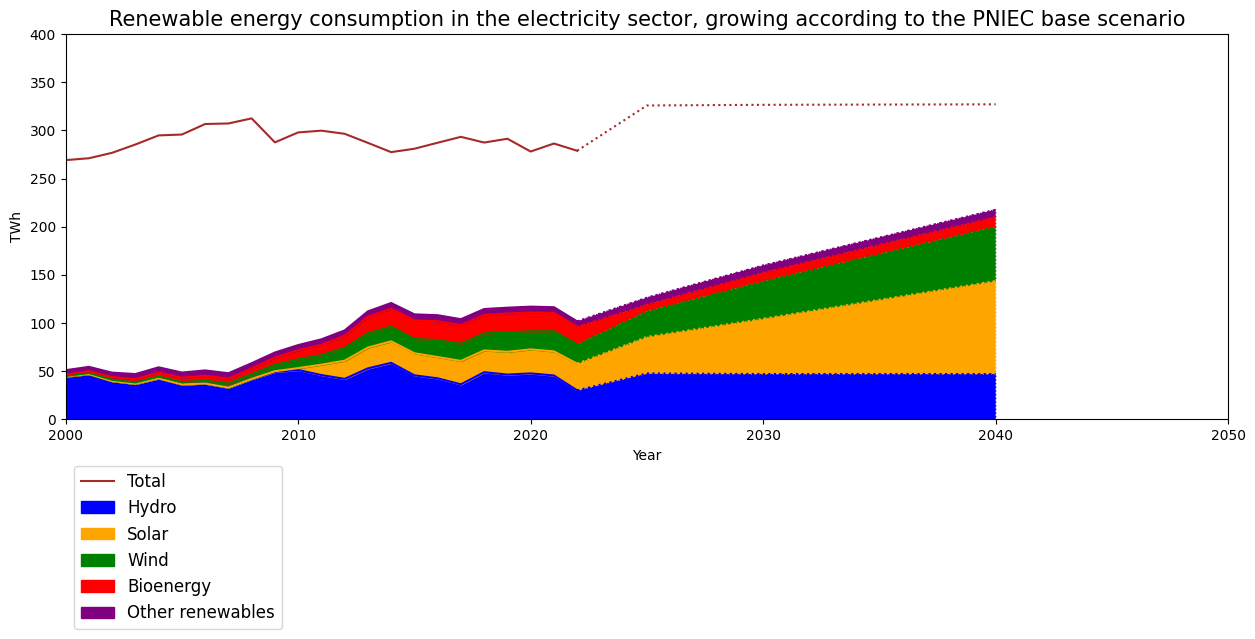

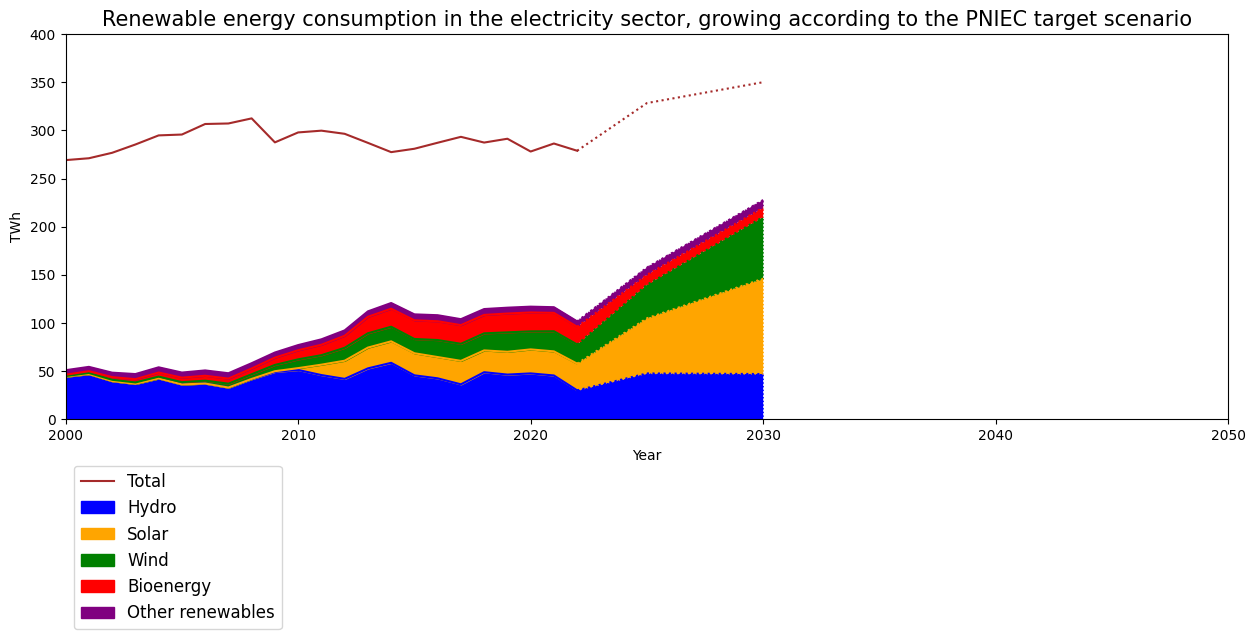

In [10]:
plot_with_predictions_stacked("Renewable energy consumption in the electricity sector, growing according to the PNIEC base scenario",
                data=history_ren_el_data,
                prediction=pniec_el_base_df)

plot_with_predictions_stacked("Renewable energy consumption in the electricity sector, growing according to the PNIEC target scenario",
                data=history_ren_el_data,
                prediction=pniec_el_target_df)

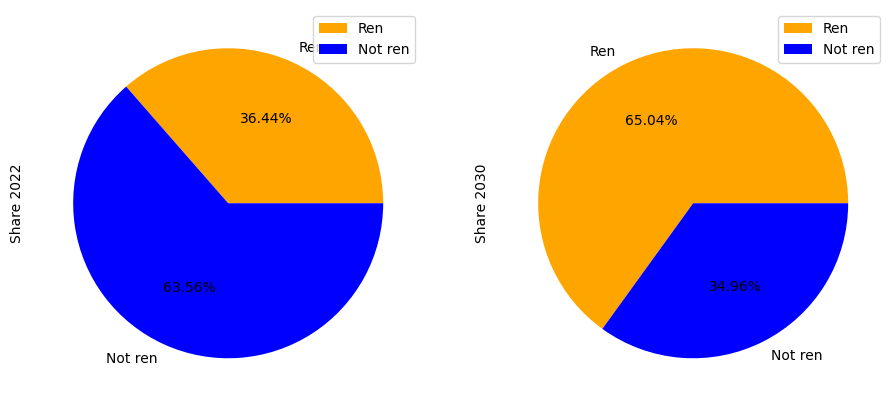

In [11]:
data_2022 = history_ren_el_data[history_ren_el_data['Year']==2022]
total_ren_2022 = ((data_2022['Hydro']+data_2022['Solar']+ \
                        data_2022['Wind']+data_2022['Bioenergy']+ \
                        data_2022['Other renewables'])/data_2022['Total']).values[0]

pie_data_2022 = pd.DataFrame([100*total_ren_2022, 100 - 100*total_ren_2022],
                            columns=['Share 2022'], index=['Ren', 'Not ren'])

data_2030 = pniec_el_target_df[pniec_el_target_df['Year']==2030]
total_ren_2030 = ((data_2030['Hydro']+data_2030['Solar']+ \
                        data_2030['Wind']+data_2030['Bioenergy']+ \
                        data_2030['Other renewables'])/data_2030['Total']).values[0]

pie_data_2030 = pd.DataFrame([100*total_ren_2030, 100 - 100*total_ren_2030],
                            columns=['Share 2030'], index=['Ren', 'Not ren'])

pie_data = pd.concat([pie_data_2022, pie_data_2030], axis=1)

plot = pie_data.plot.pie(subplots=True, figsize=(11, 6), autopct="%.2f%%", colors=['orange', 'blue', 'orange', 'blue'])

#### Renewables in the thermal sector

Regarding the thermal sector, little or no increase in the use of renewable energy is estimated for the next two decades in a current policy scenario.

The most ambitious PNIEC targets in this sector concern the use of heat pumps and bioenergy for final consumption, which currently represent the most important renewable sources in the thermal sector and are expected to raise from 2,782 and 7,171 ktep in 2021 to 6,683 and 9,879 ktep in 2030, respectively. On the other hand, geothermy, thermic solar, hydrogen and RES-based district heating will probably play a marginal role in the near future.

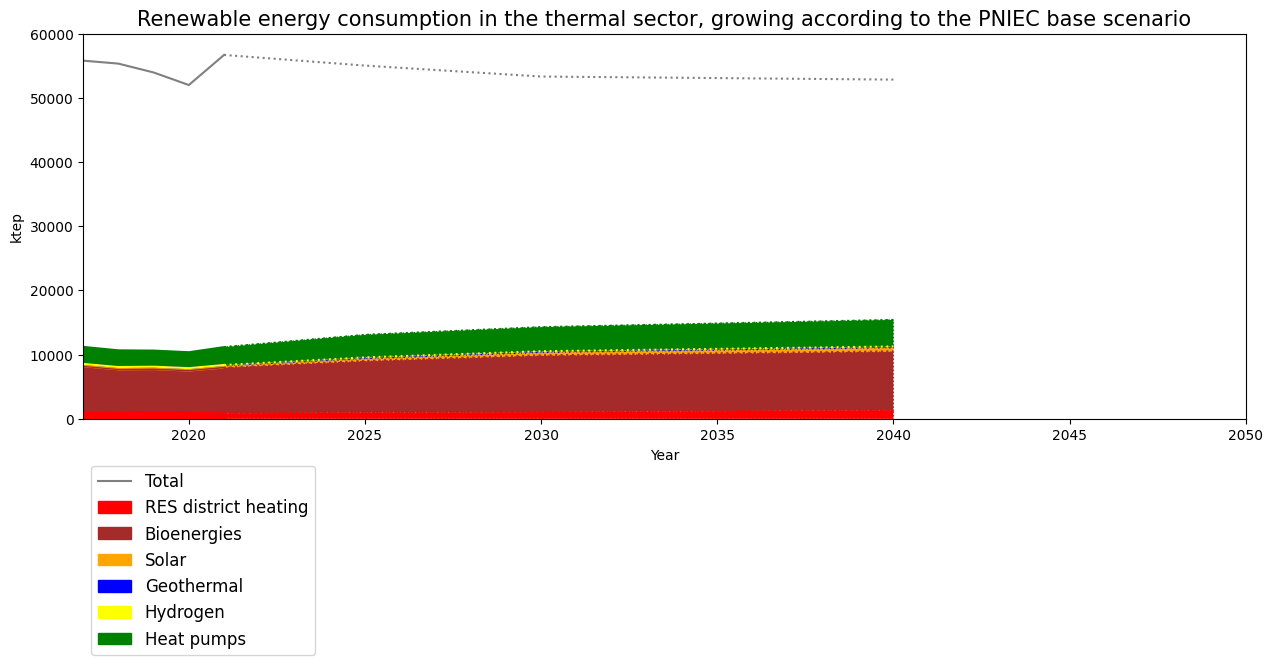

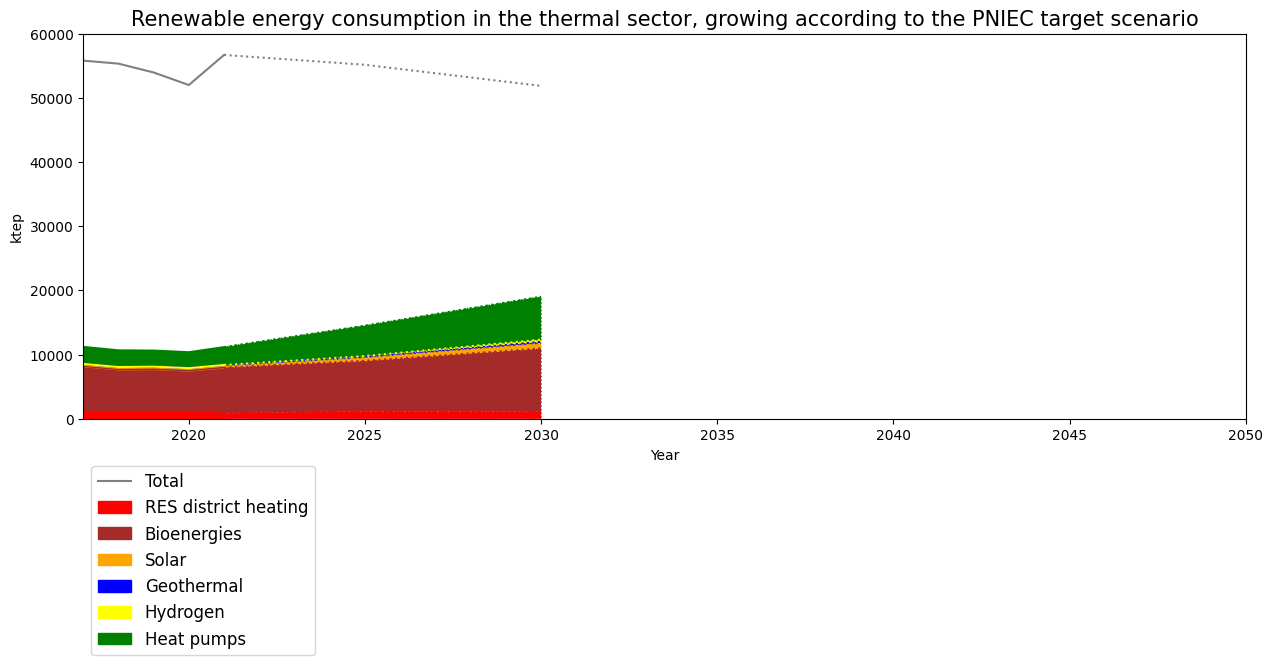

In [12]:
plot_with_predictions_stacked("Renewable energy consumption in the thermal sector, growing according to the PNIEC base scenario",
                data=pniec_therm_history_df,
                prediction=pniec_therm_base_df,
                colors=therm_colors,
                xlim=[2017, 2050],
                ylim=[0, 60000],
                y_label='ktep')

plot_with_predictions_stacked("Renewable energy consumption in the thermal sector, growing according to the PNIEC target scenario",
                data=pniec_therm_history_df,
                prediction=pniec_therm_target_df,
                colors=therm_colors,
                xlim=[2017, 2050],
                ylim=[0, 60000],
                y_label='ktep')

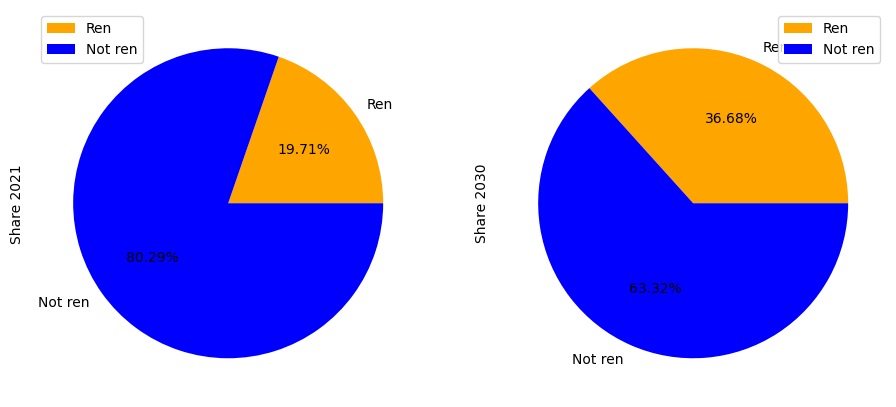

In [13]:
data_2021 = pniec_therm_history_df[pniec_therm_history_df['Year']==2021]

total_ren_2021 = ((data_2021['RES district heating']+data_2021['Bioenergies']+ \
                        data_2021['Solar']+data_2021['Geothermal']+ \
                        data_2021['Hydrogen'] + data_2021['Heat pumps'])/data_2021['Total']).values[0]

pie_data_2021 = pd.DataFrame([100*total_ren_2021, 100 - 100*total_ren_2021],
                            columns=['Share 2021'], index=['Ren', 'Not ren'])

data_2030 = pniec_therm_target_df[pniec_therm_target_df['Year']==2030]
total_ren_2030 = ((data_2030['RES district heating']+data_2030['Bioenergies']+ \
                        data_2030['Solar']+data_2030['Geothermal']+ \
                        data_2030['Hydrogen'] + data_2030['Heat pumps'])/data_2030['Total']).values[0]

pie_data_2030 = pd.DataFrame([100*total_ren_2030, 100 - 100*total_ren_2030],
                            columns=['Share 2030'], index=['Ren', 'Not ren'])

pie_data = pd.concat([pie_data_2021, pie_data_2030], axis=1)

plot = pie_data.plot.pie(subplots=True, figsize=(11, 6), autopct="%.2f%%", colors=['orange', 'blue', 'orange', 'blue'])

#### Renewables in the transport sector

The importance of a change of pace in the transition to clean energy is also evident in the transport sector, where only the 8% of the energy employed is produced using renewable sources. Biofuels and renewable electricity for road transport are the most promising resources by now, at least if we consider a near future perspective.

According to the PNIEC goals for 2030, biofuels will contibute with 7,291 ktep* to the transport energy sector in 2030, and transport clean electricity will reach 4,635 ktep* in the same year. The production of hydrogen from renewable sources, however, will probably have a negligible impact in this sector for the next two decades at least.

The share of transport energy that will come from renewable sources in 2030 should be near 31%, if the targets described above are hit.

_*the values are computed according to the criteria defined by the European Union RED III Directive._

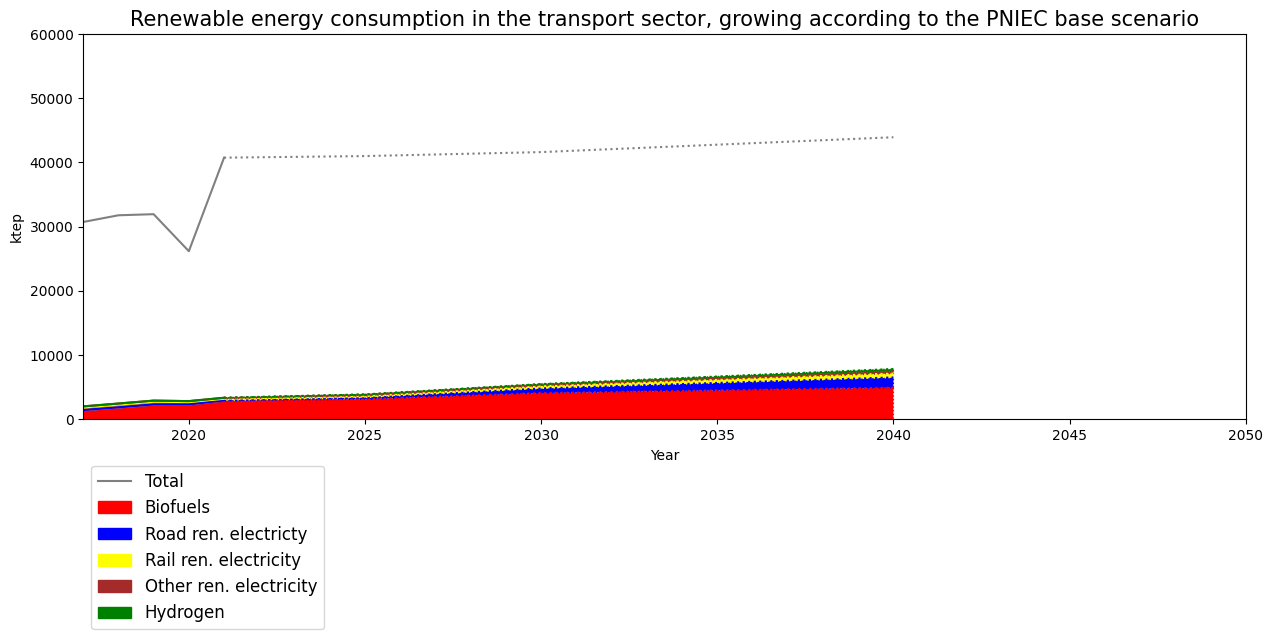

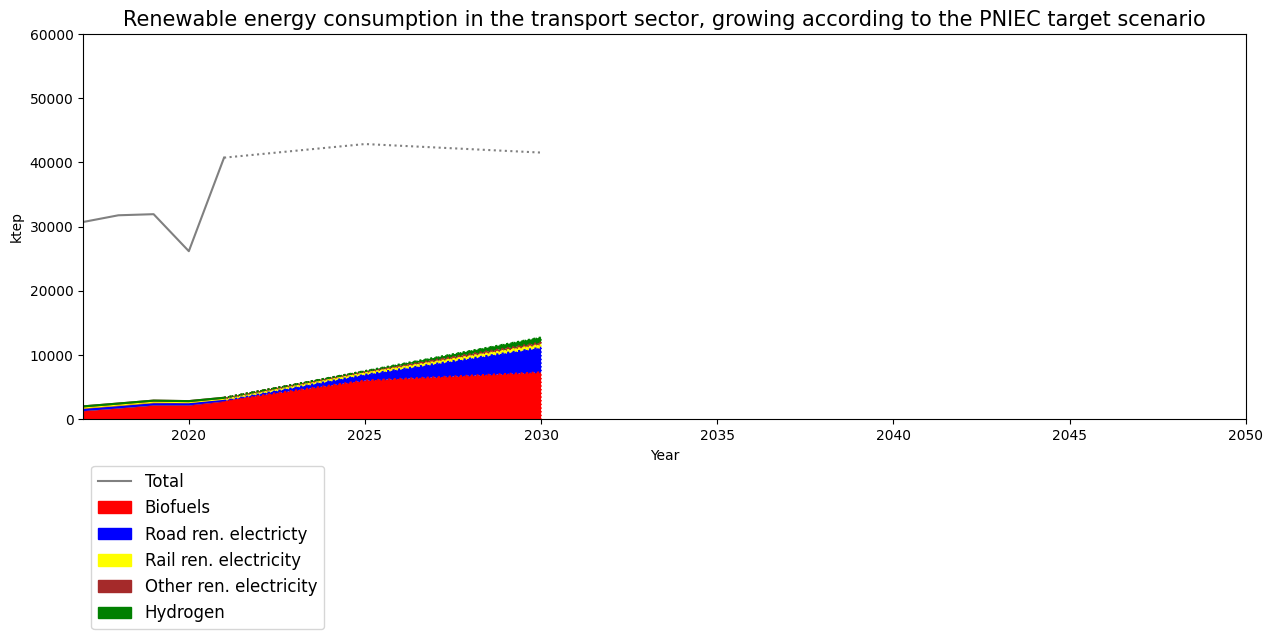

In [14]:
plot_with_predictions_stacked("Renewable energy consumption in the transport sector, growing according to the PNIEC base scenario",
                data=pniec_transp_history_df,
                prediction=pniec_transp_base_df,
                colors=transp_colors,
                xlim=[2017, 2050],
                ylim=[0, 60000],
                y_label='ktep')

plot_with_predictions_stacked("Renewable energy consumption in the transport sector, growing according to the PNIEC target scenario",
                data=pniec_transp_history_df,
                prediction=pniec_transp_target_df,
                colors=transp_colors,
                xlim=[2017, 2050],
                ylim=[0, 60000],
                y_label='ktep')

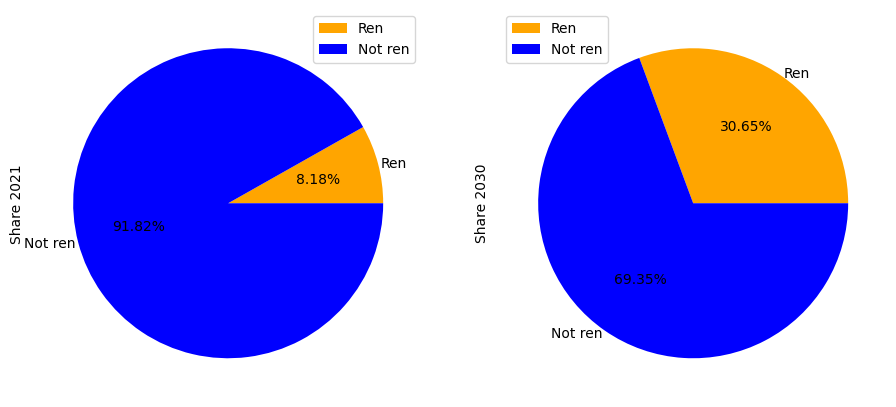

In [15]:
data_2021 = pniec_transp_history_df[pniec_transp_history_df['Year']==2021]
total_ren_2021 = ((data_2021['Biofuels']+data_2021['Road ren. electricty']+ \
                        data_2021['Rail ren. electricity']+data_2021['Other ren. electricity']+ \
                        data_2021['Hydrogen'])/data_2021['Total']).values[0]

pie_data_2021 = pd.DataFrame([100*total_ren_2021, 100 - 100*total_ren_2021],
                            columns=['Share 2021'], index=['Ren', 'Not ren'])

data_2030 = pniec_transp_target_df[pniec_transp_target_df['Year']==2030]
total_ren_2030 = ((data_2030['Biofuels']+data_2030['Road ren. electricty']+ \
                        data_2030['Rail ren. electricity']+data_2030['Other ren. electricity']+ \
                        data_2030['Hydrogen'])/data_2030['Total']).values[0]

pie_data_2030 = pd.DataFrame([100*total_ren_2030, 100 - 100*total_ren_2030],
                            columns=['Share 2030'], index=['Ren', 'Not ren'])

pie_data = pd.concat([pie_data_2021, pie_data_2030], axis=1)

plot = pie_data.plot.pie(subplots=True, figsize=(11, 6), autopct="%.2f%%", labeldistance=1.02, colors=['orange', 'blue', 'orange', 'blue'])

#### Renewables in Italy global energy consumption

Data from the electric, thermal and transport sectors can be assembled to provide a global view of the situation of renewable energy in Italy. The amount of energy produced using renewable sources should increase from 22,934 ktep in 2021 to 36,582 ktep in 2040 in a current policy scenario, whereas the Italian government plans to raise this quantity to 43,038 ktep by 2030.

Therefore, the PNIEC target for the renewable share on total energy production in Italy is around 40% by 2030, against 19% in 2021.

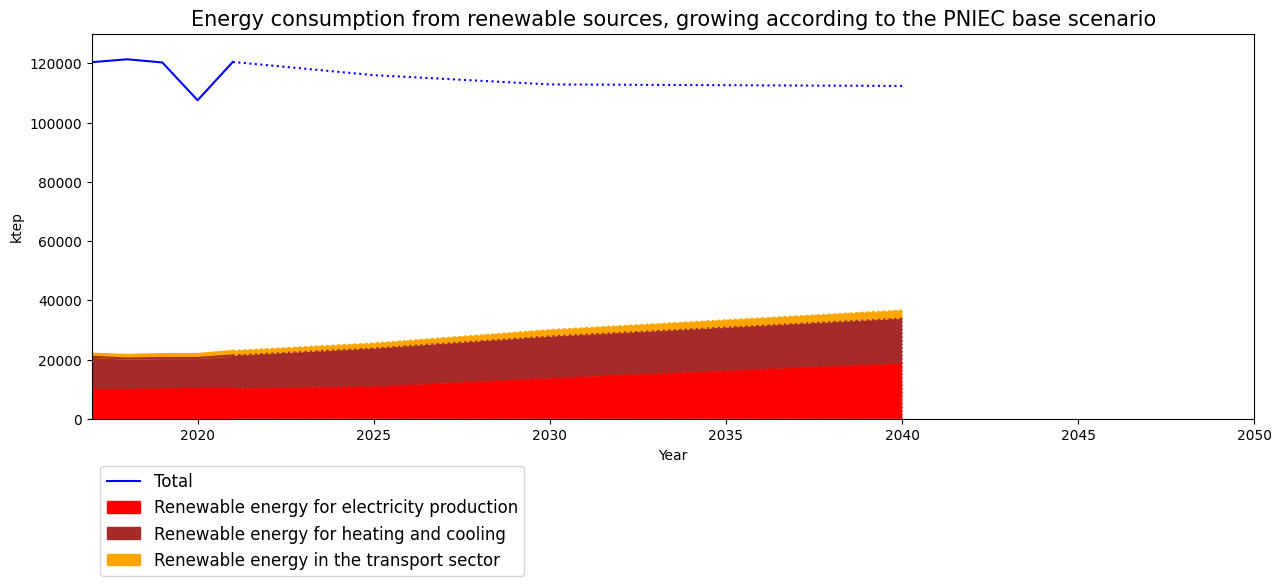

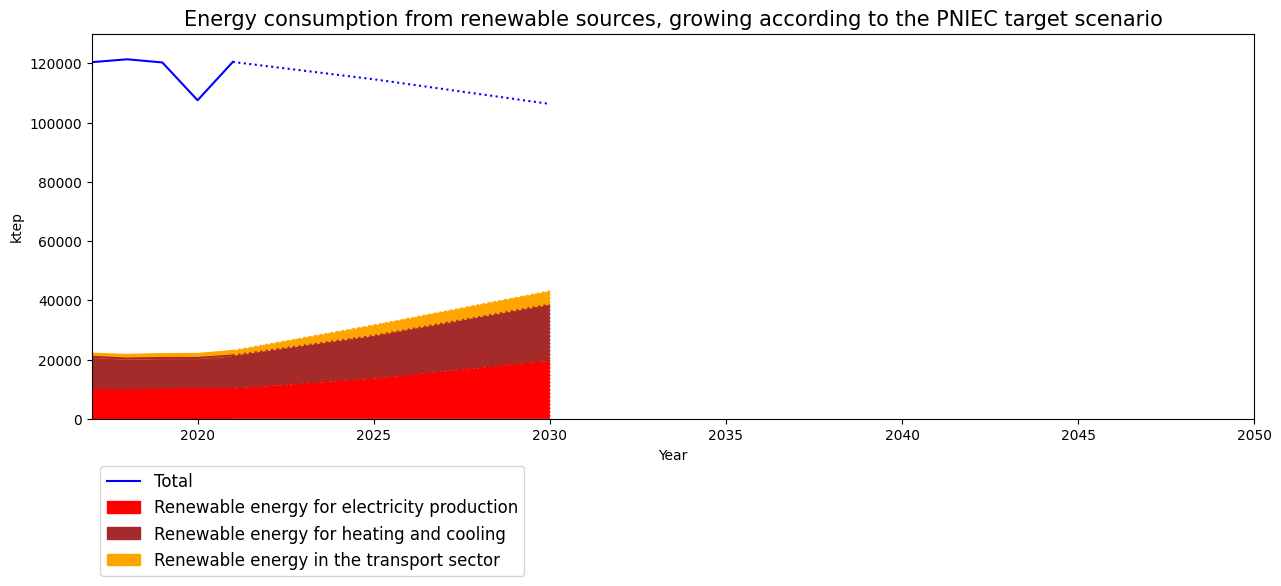

In [16]:
plot_with_predictions_stacked("Energy consumption from renewable sources, growing according to the PNIEC base scenario",
                data=pniec_global_history_df,
                prediction=pniec_global_base_df,
                colors=global_colors,
                xlim=[2017, 2050],
                ylim=[0, 130000],
                y_label='ktep')

plot_with_predictions_stacked("Energy consumption from renewable sources, growing according to the PNIEC target scenario",
                data=pniec_global_history_df,
                prediction=pniec_global_target_df,
                colors=global_colors,
                xlim=[2017, 2050],
                ylim=[0, 130000],
                y_label='ktep')

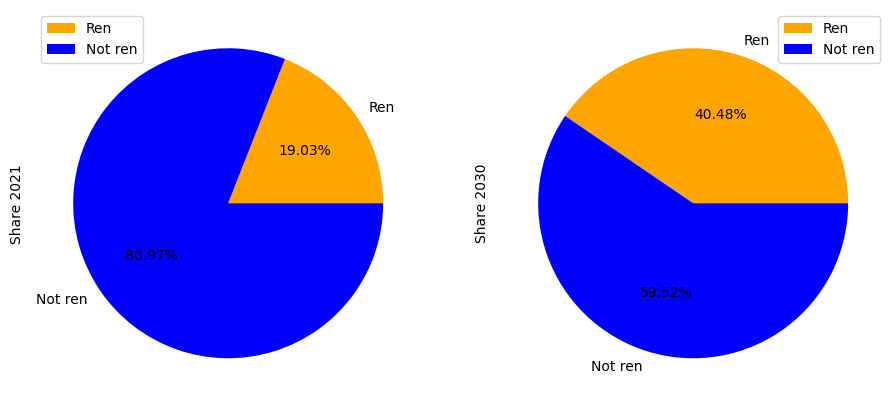

In [17]:
data_2021 = pniec_global_history_df[pniec_global_history_df['Year']==2021]
total_ren_2021 = ((data_2021['Renewable energy for electricity production']+ \
                   data_2021['Renewable energy for heating and cooling']+ \
                        data_2021['Renewable energy in the transport sector'])/data_2021['Total']).values[0]

pie_data_2021 = pd.DataFrame([100*total_ren_2021, 100 - 100*total_ren_2021],
                            columns=['Share 2021'], index=['Ren', 'Not ren'])

data_2030 = pniec_global_target_df[pniec_global_target_df['Year']==2030]
total_ren_2030 = ((data_2030['Renewable energy for electricity production']+ \
                   data_2030['Renewable energy for heating and cooling']+ \
                        data_2030['Renewable energy in the transport sector'])/data_2030['Total']).values[0]

pie_data_2030 = pd.DataFrame([100*total_ren_2030, 100 - 100*total_ren_2030],
                            columns=['Share 2030'], index=['Ren', 'Not ren'])

pie_data = pd.concat([pie_data_2021, pie_data_2030], axis=1)

plot = pie_data.plot.pie(subplots=True, figsize=(11, 6), autopct="%.2f%%", colors=['orange', 'blue', 'orange', 'blue'])

### Are the Pniec targets enough?

In the previous section, the 2030 PNIEC targets for renewable energy in Italy have been examined and compared with current policy scenarios to gain insight of the evolution of Italy's energy sector in the next future.

Here, we are interested in evaluating these goals by considering a longer time period, ranging from 2021 to 2050. For this purpose, the PNIEC renewable targets for 2030 are projected up to 2050, assuming that the same pace in the transition to renewable sources will be kept until this date.

#### Renewables in the electricity sector: projection up to 2050

In the PNIEC target scenario, the total amount of electricity consumption is supposed to increase up to 2030, probably due to the progressive diffusion of electric vehicles in the country. We assume that this increment will continue in the subsequent years, since renewable electricity is supposed to play a key role in the transport sector in the next decades.

Despite the increasing energy demand in the electricity sector, the rate of growth of renewable electricity as delineated by the PNIEC 2030 targets seems to be sufficient to reach 100% of renewable electricity production within 2050.

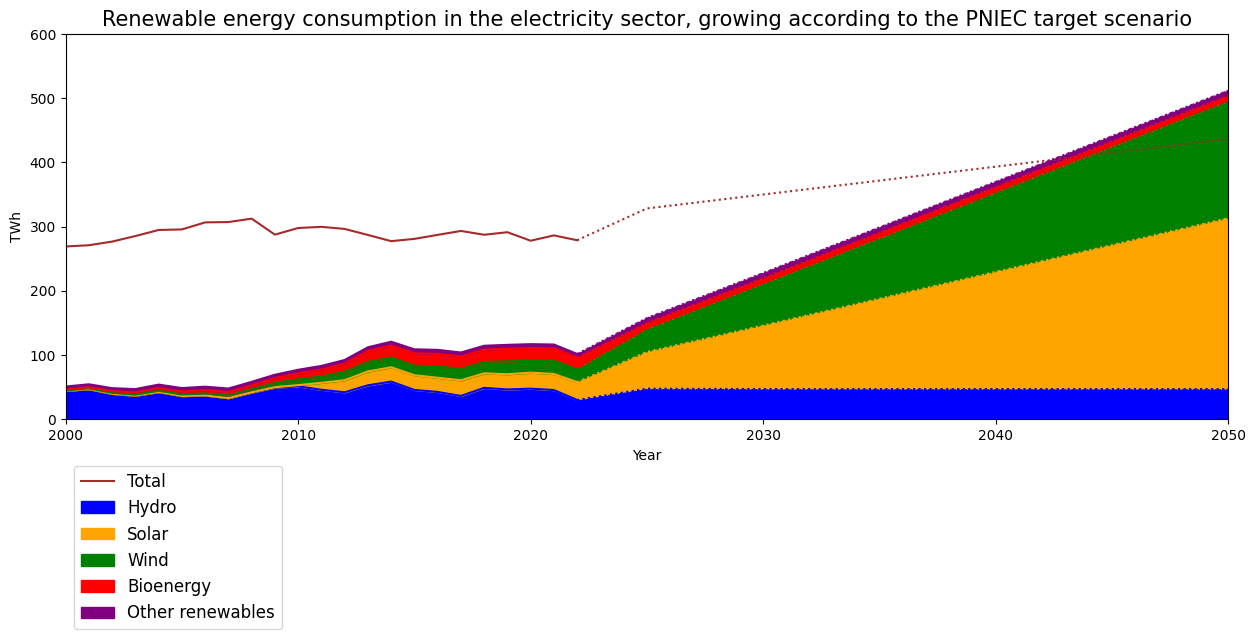

In [18]:
pniec_el_target_df_to_2050 = pniec_el_target_df.copy()

total_2030 = pniec_el_target_df_to_2050[pniec_el_target_df_to_2050['Year']==2030]['Total'].values[0]

row_2025 = pniec_el_target_df_to_2050[pniec_el_target_df_to_2050['Year']==2025].drop(columns=['Year']).reset_index(drop=True)
row_2030 = pniec_el_target_df_to_2050[pniec_el_target_df_to_2050['Year']==2030].drop(columns=['Year']).reset_index(drop=True)
annual_rate = row_2030.subtract(row_2025).divide(5)
annual_rate = annual_rate.where((annual_rate>1) | (annual_rate<-1), 0)

for year in range(2031, 2051):
    row = row_2030.add(annual_rate.multiply(year-2030))
    row['Year'] = [year]
    pniec_el_target_df_to_2050 = pniec_el_target_df_to_2050.append(row)

plot_with_predictions_stacked("Renewable energy consumption in the electricity sector, growing according to the PNIEC target scenario",
                data=history_ren_el_data,
                prediction=pniec_el_target_df_to_2050, max_stacked_value=total_2030,
                ylim=(0, 600))

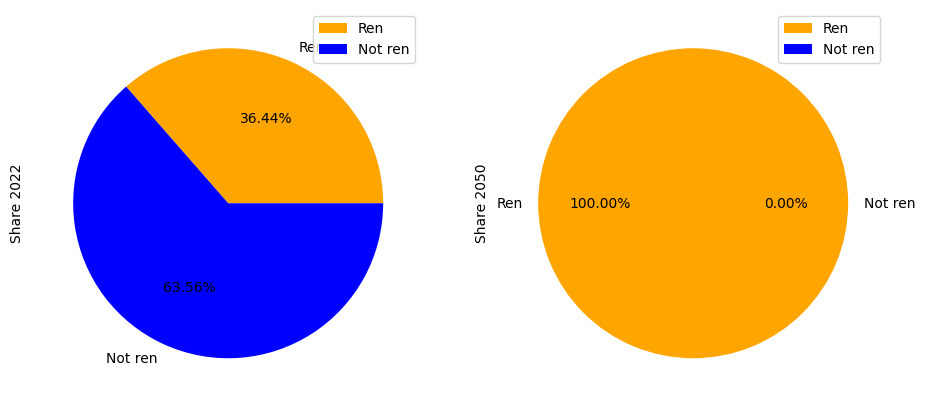

In [19]:
data_2022 = history_ren_el_data[history_ren_el_data['Year']==2022]
total_ren_2022 = ((data_2022['Hydro']+data_2022['Solar']+ \
                        data_2022['Wind']+data_2022['Bioenergy']+ \
                        data_2022['Other renewables'])/data_2022['Total']).values[0]

pie_data_2022 = pd.DataFrame([100*total_ren_2022, 100 - 100*total_ren_2022],
                            columns=['Share 2022'], index=['Ren', 'Not ren'])

data_2050 = pniec_el_target_df_to_2050[pniec_el_target_df_to_2050['Year']==2050]
total_ren_2050 = ((data_2050['Hydro']+data_2050['Solar']+ \
                        data_2050['Wind']+data_2050['Bioenergy']+ \
                        data_2050['Other renewables'])/data_2050['Total']).values[0]
total_ren_2050 = min(total_ren_2050, 0.999999)

pie_data_2050 = pd.DataFrame([100*total_ren_2050, 100 - 100*total_ren_2050],
                            columns=['Share 2050'], index=['Ren', 'Not ren'])

pie_data = pd.concat([pie_data_2022, pie_data_2050], axis=1)

plot = pie_data.plot.pie(subplots=True, figsize=(11, 6), autopct="%.2f%%", colors=['orange', 'blue', 'orange', 'blue'])

#### Renewables in the thermal sector: projection up to 2050

Using hydrogen from renewable sources as an energy vector in the thermal and transport sector is a relatively new idea and it is difficult to predict how it is going to evolve in the future. If no acceleration will take place from 2030 onwards, however, the role that this resource will play in the thermal sector will still be marginal in 2050.

In this scenario, the majority of the energy used in Italy for heating and cooling applications in 2050 will be produced using renewable bioenergies and heat pumps; however, non-renewable sources like natural gas and other fossil fuels will still represent around 29% of the total energy consumptions in this sector.

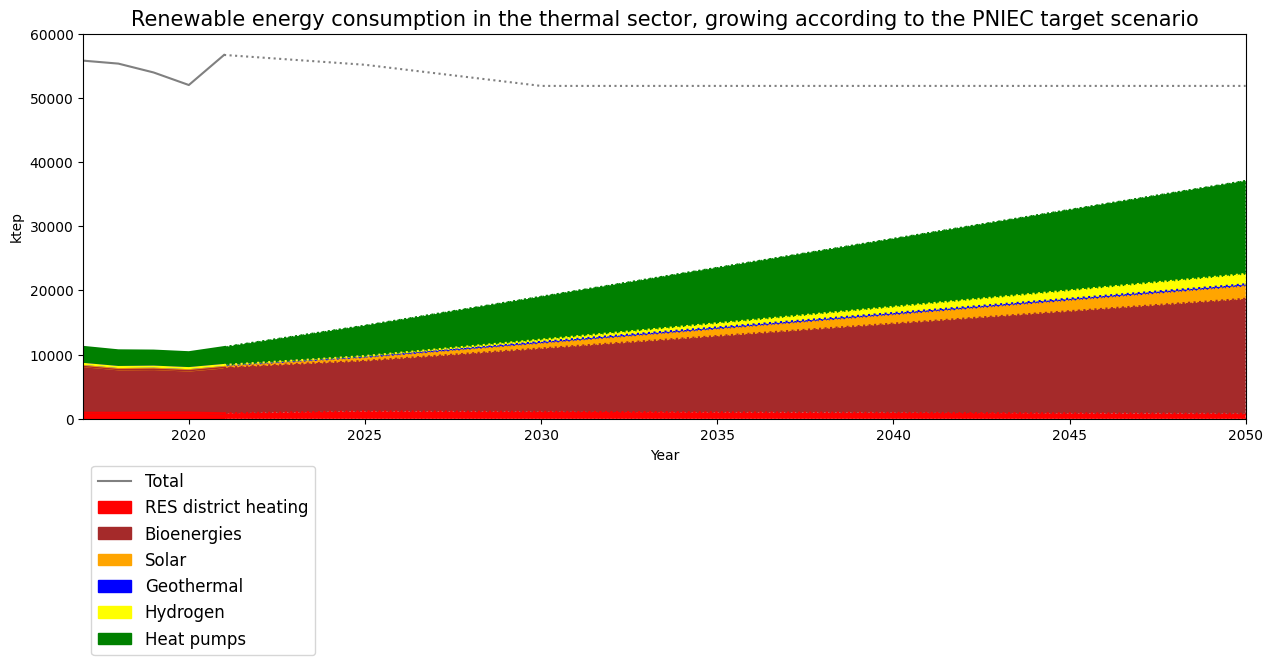

In [20]:
pniec_therm_target_df_to_2050 = pniec_therm_target_df.copy()

total_2030 = pniec_therm_target_df_to_2050[pniec_therm_target_df_to_2050['Year']==2030]['Total'].values[0]

row_2025 = pniec_therm_target_df_to_2050[pniec_therm_target_df_to_2050['Year']==2025].drop(columns=['Year', 'Total']).reset_index(drop=True)
row_2030 = pniec_therm_target_df_to_2050[pniec_therm_target_df_to_2050['Year']==2030].drop(columns=['Year', 'Total']).reset_index(drop=True)
annual_rate = row_2030.subtract(row_2025).divide(5)
annual_rate = annual_rate.where((annual_rate>1) | (annual_rate<-1), 0)

for year in range(2031, 2051):
    row = row_2030.add(annual_rate.multiply(year-2030))
    row['Year'] = [year]
    row['Total'] = [total_2030]
    pniec_therm_target_df_to_2050 = pniec_therm_target_df_to_2050.append(row)
   

plot_with_predictions_stacked("Renewable energy consumption in the thermal sector, growing according to the PNIEC target scenario",
                data=pniec_therm_history_df,
                prediction=pniec_therm_target_df_to_2050,
                colors=therm_colors,
                xlim=[2017, 2050],
                ylim=[0, 60000],
                y_label='ktep',
                max_stacked_value=total_2030)

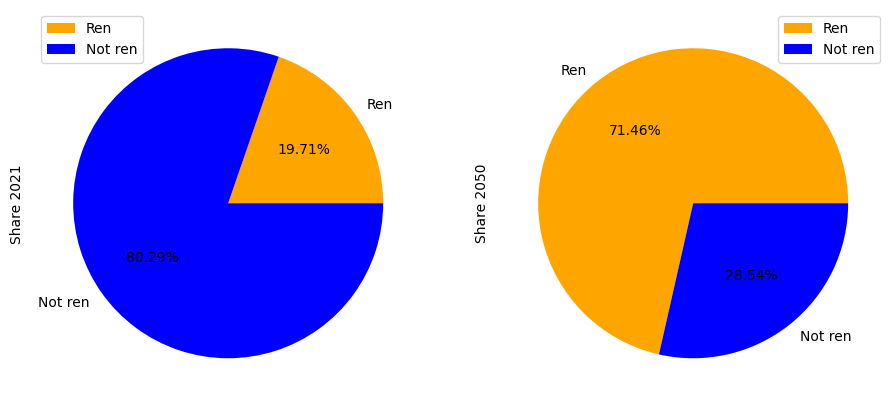

In [21]:
data_2021 = pniec_therm_history_df[pniec_therm_history_df['Year']==2021]
total_ren_2021 = ((data_2021['RES district heating']+data_2021['Bioenergies']+ \
                        data_2021['Solar']+data_2021['Geothermal']+ \
                        data_2021['Hydrogen'] + data_2021['Heat pumps'])/data_2021['Total']).values[0]

pie_data_2021 = pd.DataFrame([100*total_ren_2021, 100 - 100*total_ren_2021],
                            columns=['Share 2021'], index=['Ren', 'Not ren'])

data_2050 = pniec_therm_target_df_to_2050[pniec_therm_target_df_to_2050['Year']==2050]
total_ren_2050 = ((data_2050['RES district heating']+data_2050['Bioenergies']+ \
                        data_2050['Solar']+data_2050['Geothermal']+ \
                        data_2050['Hydrogen'] + data_2050['Heat pumps'])/data_2050['Total']).values[0]
total_ren_2050 = min(total_ren_2050, 0.999999)

pie_data_2050 = pd.DataFrame([100*total_ren_2050, 100 - 100*total_ren_2050],
                            columns=['Share 2050'], index=['Ren', 'Not ren'])

pie_data = pd.concat([pie_data_2021, pie_data_2050], axis=1)

plot = pie_data.plot.pie(subplots=True, figsize=(11, 6), autopct="%.2f%%", colors=['orange', 'blue', 'orange', 'blue'])

#### Renewables in the transport sector: projection up to 2050

By projecting the PNIEC renewable goals for 2030 up to 2050, we obtain an 81% of renewable energy in the transport sector, most of which coming from biofuels and renewable electricity for road electric vehicles, plus a moderate contribution from hydrogen production.

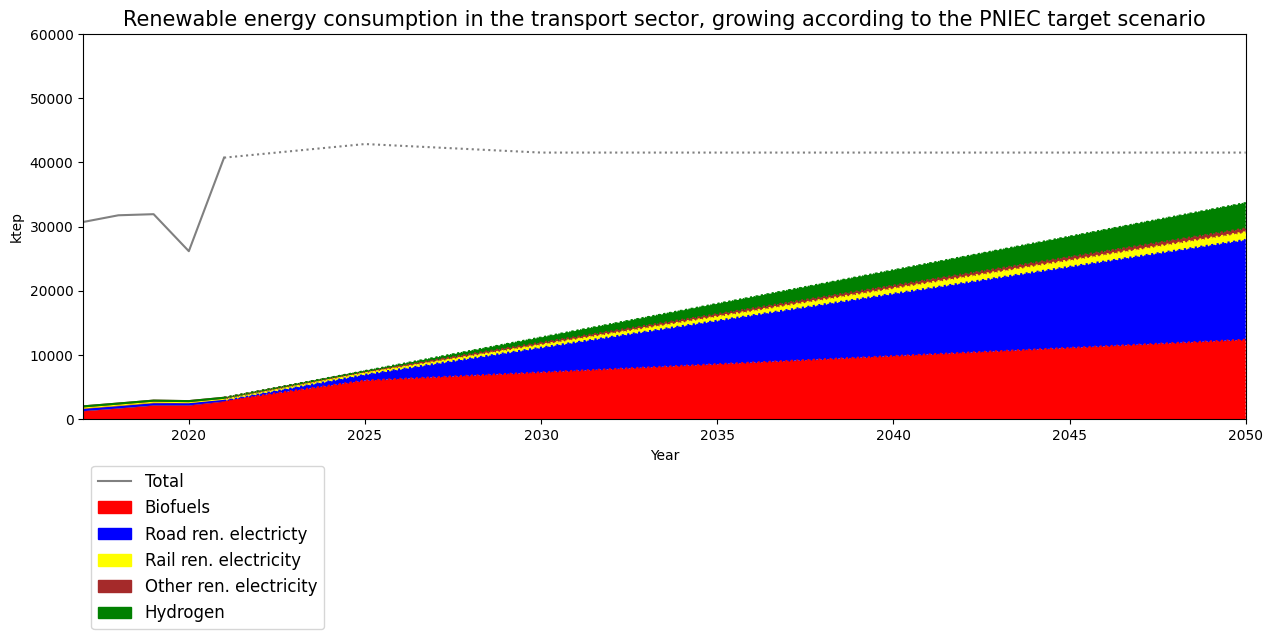

In [22]:
pniec_transp_target_df_to_2050 = pniec_transp_target_df.copy()

total_2030 = pniec_transp_target_df_to_2050[pniec_transp_target_df_to_2050['Year']==2030]['Total'].values[0]

row_2025 = pniec_transp_target_df_to_2050[pniec_transp_target_df_to_2050['Year']==2025].drop(columns=['Year', 'Total']).reset_index(drop=True)
row_2030 = pniec_transp_target_df_to_2050[pniec_transp_target_df_to_2050['Year']==2030].drop(columns=['Year', 'Total']).reset_index(drop=True)
annual_rate = row_2030.subtract(row_2025).divide(5)
annual_rate = annual_rate.where((annual_rate>1) | (annual_rate<-1), 0)

for year in range(2031, 2051):
    row = row_2030.add(annual_rate.multiply(year-2030))
    row['Year'] = [year]
    row['Total'] = [total_2030]
    pniec_transp_target_df_to_2050 = pniec_transp_target_df_to_2050.append(row)
   

plot_with_predictions_stacked("Renewable energy consumption in the transport sector, growing according to the PNIEC target scenario",
                data=pniec_transp_history_df,
                prediction=pniec_transp_target_df_to_2050,
                colors=transp_colors,
                xlim=[2017, 2050],
                ylim=[0, 60000],
                y_label='ktep',
                max_stacked_value=total_2030)

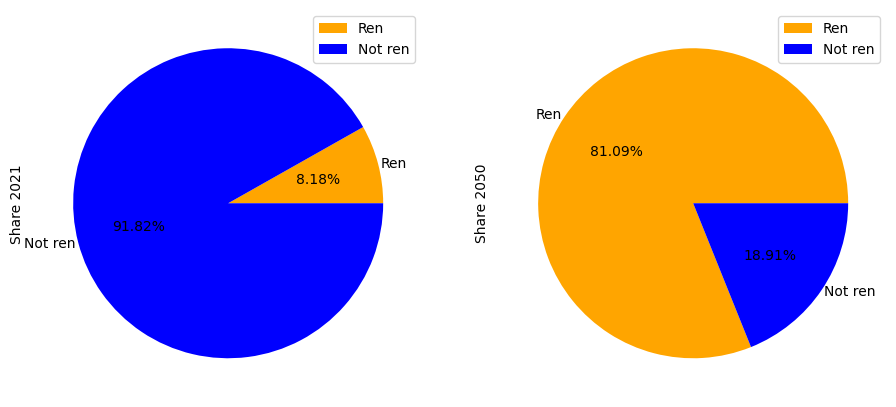

In [23]:
data_2021 = pniec_transp_history_df[pniec_transp_history_df['Year']==2021]
total_ren_2021 = ((data_2021['Biofuels']+data_2021['Road ren. electricty']+ \
                        data_2021['Rail ren. electricity']+data_2021['Other ren. electricity']+ \
                        data_2021['Hydrogen'])/data_2021['Total']).values[0]

pie_data_2021 = pd.DataFrame([100*total_ren_2021, 100 - 100*total_ren_2021],
                            columns=['Share 2021'], index=['Ren', 'Not ren'])

data_2050 = pniec_transp_target_df_to_2050[pniec_transp_target_df_to_2050['Year']==2050]
total_ren_2050 = ((data_2050['Biofuels']+data_2050['Road ren. electricty']+ \
                        data_2050['Rail ren. electricity']+data_2050['Other ren. electricity']+ \
                        data_2050['Hydrogen'])/data_2050['Total']).values[0]
total_ren_2050 = min(total_ren_2050, 0.999999)

pie_data_2050 = pd.DataFrame([100*total_ren_2050, 100 - 100*total_ren_2050],
                            columns=['Share 2050'], index=['Ren', 'Not ren'])

pie_data = pd.concat([pie_data_2021, pie_data_2050], axis=1)

plot = pie_data.plot.pie(subplots=True, figsize=(11, 6), autopct="%.2f%%", labeldistance=1.02, colors=['orange', 'blue', 'orange', 'blue'])

#### Renewables in Italy global energy production: projection up to 2050 and EU targets comparison

In this section, a global overview of the evolution of renewable energy in Italy up to 2050 is presented, under the assumption that the PNIEC targets for 2030 will be accomplished and that the pace they set in the transition to renewables will remain the same in the subsequent decades. Although some approximations are likely to be introduced by this simple approach, the results obtained in this way can be useful to determined whether the 2030 PNIEC targets are aligned with the goal of climate neutrality within 2050, or further accelerations will be needed in the period from 2030 to 2050.

As shown in the charts below, Italy is currently aligned with the 2020 EU target for renewable energy production, and is going to vastly exceed the goal of 32% of renewables in 2030, if the PNIEC targets up to this date are met. On 30 March 2023, however, the European Parliament and the Council reached a provisional agreement to raise the 2030 EU renewable energy target to at least 42.5%, which is slightly higher than the 40.5% share predicted by the Italian government.

Regarding longer term forecasts, the European Union has set the ambitious objective of reaching complete climate neutrality within 2050. If we assume that the rate of growth of renewable energy as defined by the 2030 PNIEC targets will remain the same in the subsequent decades, it follows that the share of renewable energy in Italy will grow up to 84% in 2050.

In order to fulfill the 2050 climate neutrality target, increased efforts will be needed in the period from 2030 to 2050, possibly consisting of an acceleration in the rate of growth of currently used renewable sources, or in the introduction of other low-carbon sources, like nuclear power, in Italy's energy mix.

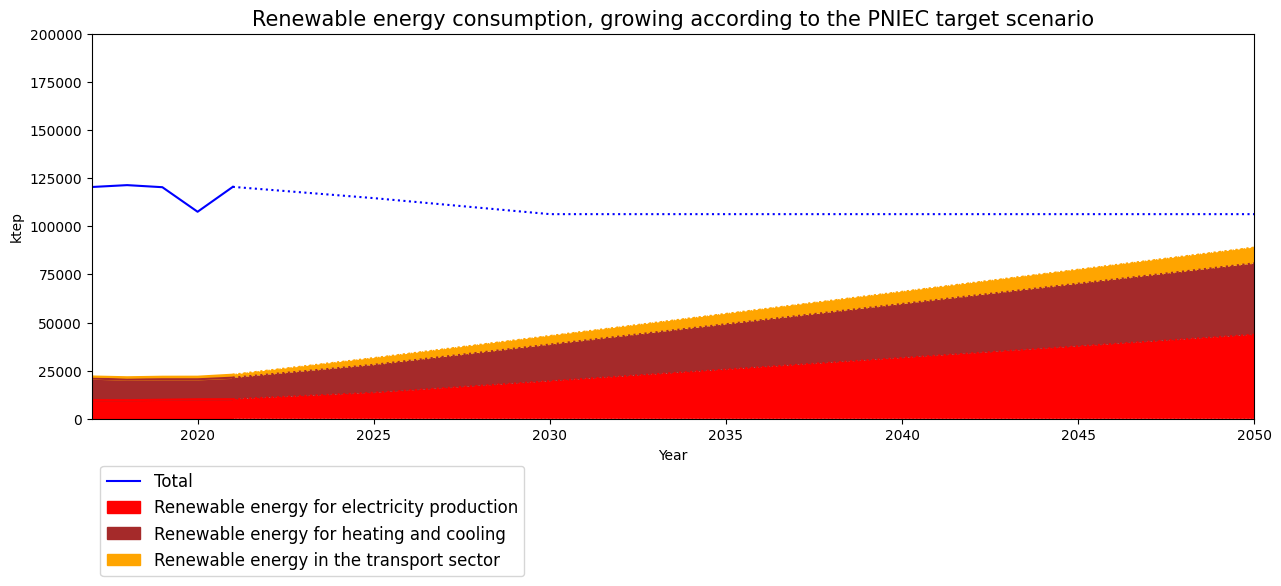

In [24]:
pniec_global_target_df_to_2050 = pniec_global_target_df.copy()

total_2030 = pniec_global_target_df_to_2050[pniec_global_target_df_to_2050['Year']==2030]['Total'].values[0]

row_2025 = pniec_global_target_df_to_2050[pniec_global_target_df_to_2050['Year']==2025].drop(columns=['Year', 'Total']).reset_index(drop=True)
row_2030 = pniec_global_target_df_to_2050[pniec_global_target_df_to_2050['Year']==2030].drop(columns=['Year', 'Total']).reset_index(drop=True)
annual_rate = row_2030.subtract(row_2025).divide(5)
annual_rate = annual_rate.where((annual_rate>1) | (annual_rate<-1), 0)

for year in range(2031, 2051):
    row = row_2030.add(annual_rate.multiply(year-2030))
    row['Year'] = [year]
    row['Total'] = [total_2030]
    pniec_global_target_df_to_2050 = pniec_global_target_df_to_2050.append(row)
   

plot_with_predictions_stacked("Renewable energy consumption, growing according to the PNIEC target scenario",
                data=pniec_global_history_df,
                prediction=pniec_global_target_df_to_2050,
                colors=global_colors,
                xlim=[2017, 2050],
                ylim=[0, 200000],
                y_label='ktep',
                max_stacked_value=total_2030)

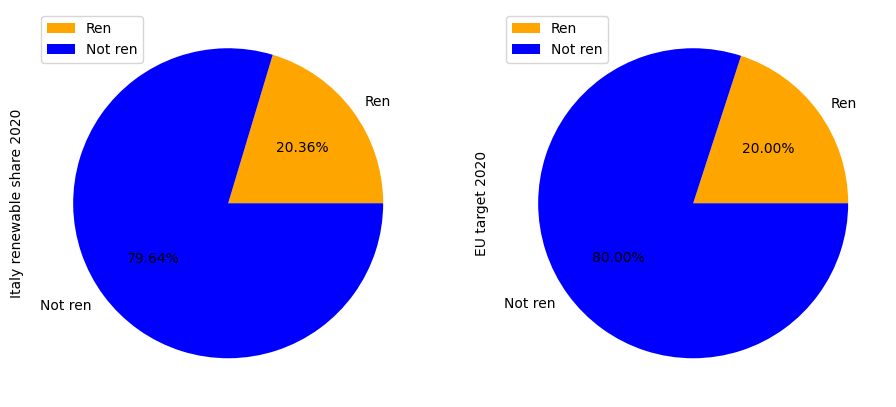

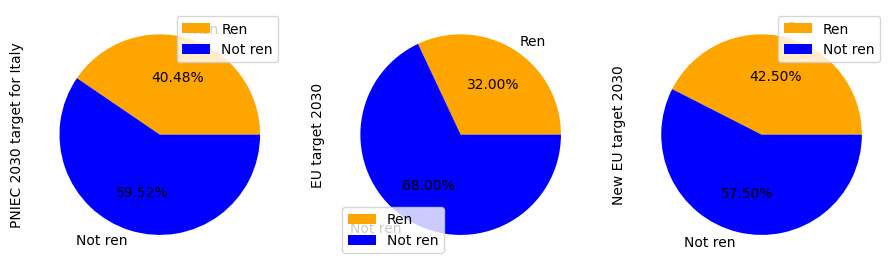

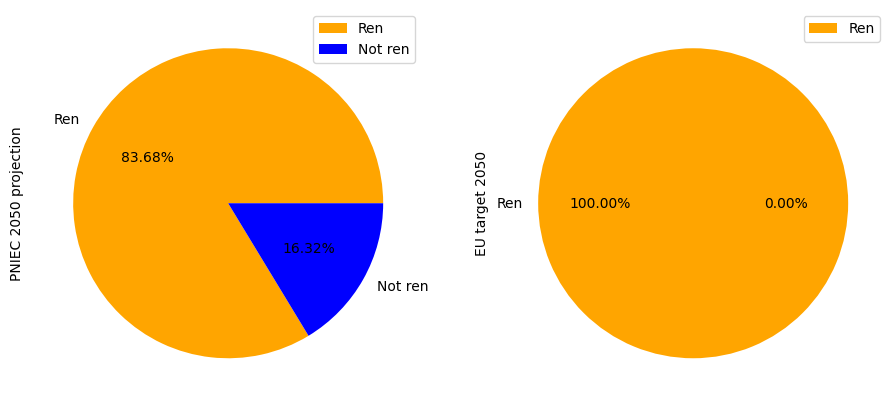

In [25]:
data_2020 = pniec_global_history_df[pniec_global_history_df['Year']==2020]
total_ren_2020 = ((data_2020['Renewable energy for electricity production']+ \
                   data_2020['Renewable energy for heating and cooling']+ \
                        data_2020['Renewable energy in the transport sector'])/data_2020['Total']).values[0]
pie_data_2020 = pd.DataFrame([100*total_ren_2020, 100 - 100*total_ren_2020],
                            columns=['Italy renewable share 2020'], index=['Ren', 'Not ren'])

pie_data_2020_eu = pd.DataFrame([20, 80], columns=['EU target 2020'], index=['Ren', 'Not ren'])

pie_data = pd.concat([pie_data_2020, pie_data_2020_eu], axis=1)
plot = pie_data.plot.pie(subplots=True, figsize=(11, 6), autopct="%.2f%%", colors=['orange', 'blue', 'orange', 'blue'])



data_2030 = pniec_global_target_df_to_2050[pniec_global_target_df_to_2050['Year']==2030]
total_ren_2030 = ((data_2030['Renewable energy for electricity production']+ \
                   data_2030['Renewable energy for heating and cooling']+ \
                        data_2030['Renewable energy in the transport sector'])/data_2030['Total']).values[0]
total_ren_2030 = min(total_ren_2030, 0.999999)
pie_data_2030 = pd.DataFrame([100*total_ren_2030, 100 - 100*total_ren_2030],
                            columns=['PNIEC 2030 target for Italy'], index=['Ren', 'Not ren'])

pie_data_2030_eu = pd.DataFrame([32, 68], columns=['EU target 2030'], index=['Ren', 'Not ren'])
new_pie_data_2030_eu = pd.DataFrame([42.5, 57.5], columns=['New EU target 2030'], index=['Ren', 'Not ren'])

pie_data = pd.concat([pie_data_2030, pie_data_2030_eu, new_pie_data_2030_eu], axis=1)
plot = pie_data.plot.pie(subplots=True, figsize=(11, 6), autopct="%.2f%%", colors=['orange', 'blue', 'orange', 'blue'])



data_2050 = pniec_global_target_df_to_2050[pniec_global_target_df_to_2050['Year']==2050]
total_ren_2050 = ((data_2050['Renewable energy for electricity production']+ \
                   data_2050['Renewable energy for heating and cooling']+ \
                        data_2050['Renewable energy in the transport sector'])/data_2050['Total']).values[0]
total_ren_2050 = min(total_ren_2050, 0.999999)
pie_data_2050 = pd.DataFrame([100*total_ren_2050, 100 - 100*total_ren_2050],
                            columns=['PNIEC 2050 projection'], index=['Ren', 'Not ren'])

pie_data_2050_eu = pd.DataFrame([100, 0], columns=['EU target 2050'], index=['Ren', 'Not ren'])

pie_data = pd.concat([pie_data_2050, pie_data_2050_eu], axis=1)
plot = pie_data.plot.pie(subplots=True, figsize=(11, 6), autopct="%.2f%%", colors=['orange', 'blue', 'orange', 'blue'])

## Energy security

The ultimate goal of the energy transition in Italy and in the EU is the elimination of non-renewable sources from the energy mix of the country. Fossil fuels like natural gas and petroleum, however, will continue to play a key role in the near future and cannot be rapidly replaced by other energy sources. Securing the supply of these raw materials is the most critical objective of the PNIEC energy security strategy, especially regarding natural gas.

### The Ukraine war and the Russian gas

In 2021, 76.1 bcm (billions of cubic meters) of natural gas have been consumed in Italy, compared to a national production of 3.3 bcm in the same year. The vast majority of the natural gas used by Italy, namely 72.7 bcm, have been imported by other countries through pipelines or LNG (Liquefied Natural Gas) carrier ships.

Italy's importations of natural gas across the years are depicted in the chart below, as reported by the Italian Ministry for the Ecologic Transition. The most relevant contribution in this sense is given by Russia, Algeria and Azerbaijan, through the Nord Stream, the Transmed and the Trans Adriatic Pipeline (TAP), respectively. A significant amount of LNG comes from Quatar and the United States, and the remaining demand is satisfied by some other countries, like Libya, Norway and the Netherlands.

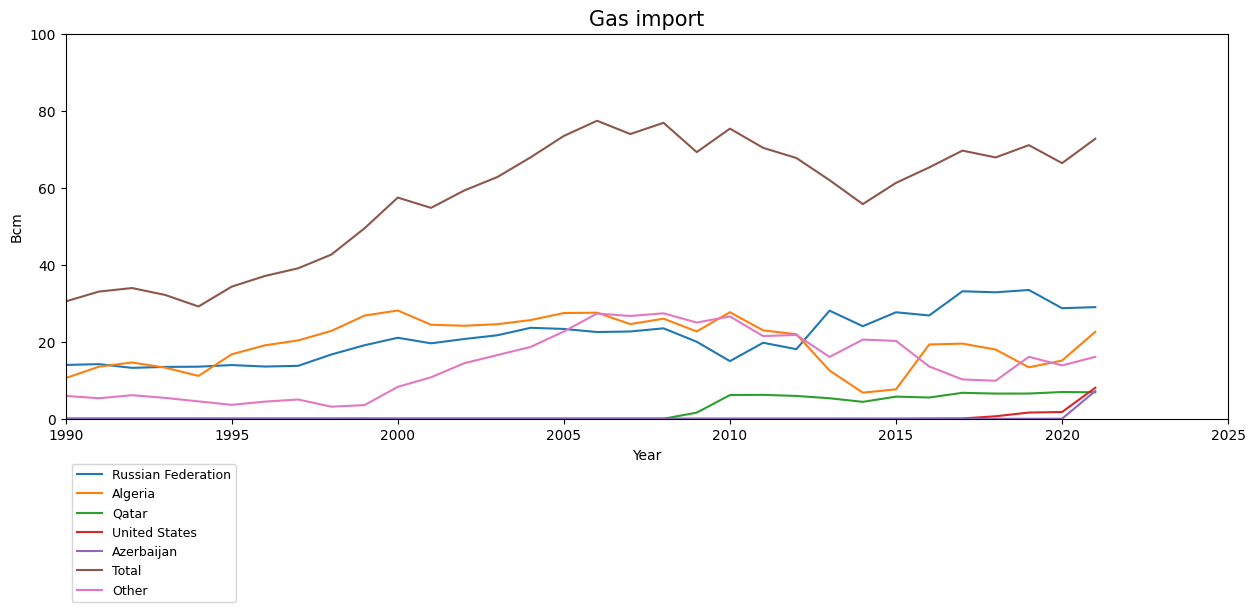

In [26]:
gas_import_data = pd.read_csv('data/ImportazioniGasAnnualiPerPaeseDiOrigine_1990-2021.csv', sep=';')

gas_import_data = gas_import_data.rename(columns={'Milioni di metri cubi': 'Year'})
gas_import_data = gas_import_data.set_index('Year')
gas_import_data = gas_import_data.transpose()
gas_import_data['Year'] = gas_import_data.index

gas_import_data = gas_import_data.rename(columns={'Totale': 'Total'})

gas_import_data = gas_import_data.fillna(0)

#print(gas_import_data[gas_import_data['Year']=='2021'])
        
def remove_dots(x):
    x = str(x).strip()
    if x=='-':
        return 0
    else:
        return float(str(x).replace('.', ''))
gas_import_data = gas_import_data.apply(lambda row: row.apply(remove_dots))


gas_import_data['Other'] = np.zeros((len(gas_import_data)))
#print(gas_import_data)
for column in gas_import_data.columns:
    if column=='Year' or column=='Other':
        continue
    gas_import_data[column] = gas_import_data[column].divide(1000)
    if gas_import_data[gas_import_data['Year']==2021][column].iloc[0] < 5:
        gas_import_data['Other'] = gas_import_data['Other'] + gas_import_data[column]
        gas_import_data = gas_import_data.drop(columns=[column])
        
fig, ax = plt.subplots(figsize=(15, 5))
ax.set_title('Gas import', fontsize=15)
ax.set_ylabel('Bcm')
ax.set_xlabel('Year')

gas_import_data.plot.line(ax=ax, x='Year', linestyle='-')

ax.legend(fontsize=9, loc='upper left', bbox_to_anchor=(0.0, -0.1))
plt.xlim((1990, 2025))
plt.ylim((0, 100))

plt.show()

As mentioned above, the most relevant country for Italy's natural gas import up to 2021 was the Russian Federation. In 2022, the russian invasion of Ukraine has led to a radical worsening of the relations between the Russian Federation and the European Union; as a consequence, achieving independence from russian energetic resources is now considered as a priority by most european countries, including Italy.

The italian government has identified three main directions for the reduction of russian natural gas imports in the next years (w.r.t. 2021):
- 11.9 bcm of additional pipeline gas imports are expected in 2025 by Algeria (+9.0), Azerbaijan (+1.5) and increased national production (+1.4);
- an increment of 12.7 bcm of imported LNG is planned for the same year, coming from Egypt (3.5), Congo (4.6), Qatar (1.4), Angola (1.0) and other (2.2);
- finally, 10.9 bcm of natural gas can be saved by reducing thermic and electric consumptions (+2.0) and by increasing the production of renewable electricity (+7.3) and biofuels (+1.6).

Since the italian import of russian gas in 2021 was around 29 bcm, the combined action of the measures described above seems to be enough to set this amount to zero within 2025.

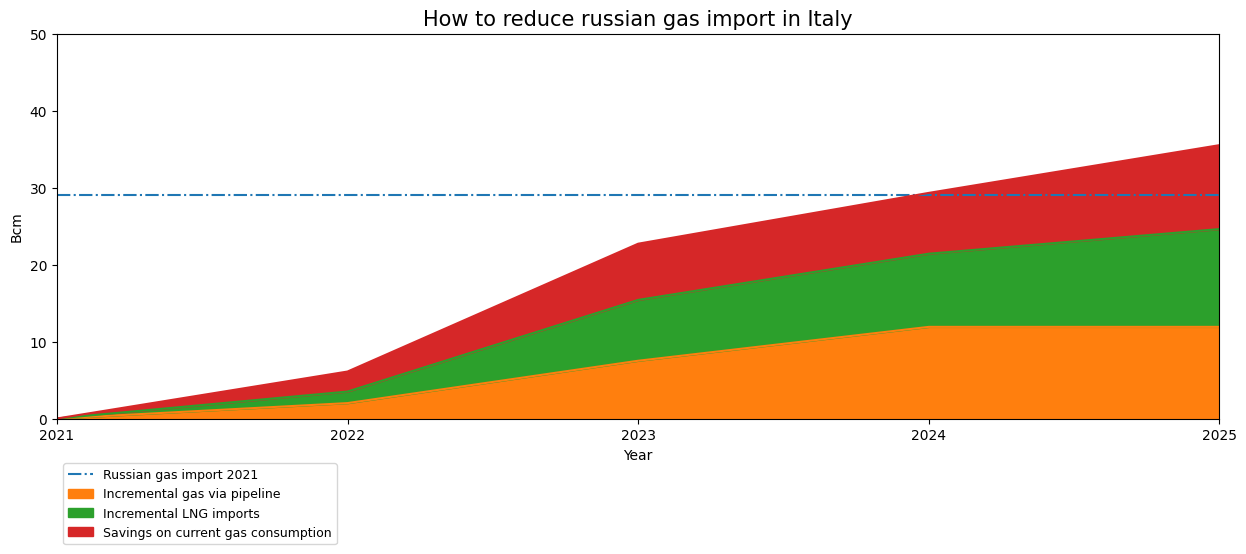

In [27]:
gas_increment_areas = ['Incremental gas via pipeline', 'Incremental LNG imports', \
                 'Savings on current gas consumption']
gas_increment_colors = dict(zip(gas_increment_areas, ['red', 'blue', 'green', 'brown']))
gas_increment_columns = gas_increment_areas
gas_increment_columns.insert(0, 'Year')

pniec_gas_increment_history_df = pd.DataFrame([
        [2021, 28.988],
        [2025, 28.988]
    ],
    columns=['Year', 'Russian gas import 2021'])

pniec_gas_increment_target_df = pd.DataFrame([
    [2021, 0, 0, 0],
    [2022, 2.0, 1.5, 2.6],
    [2023, 7.5, 7.9, 7.3],
    [2024, 11.9, 9.5, 7.9],
    [2025, 11.9, 12.7, 10.9]
    ], columns=gas_increment_columns)


fig, ax = plt.subplots(figsize=(15, 5))
ax.set_title('How to reduce russian gas import in Italy', fontsize=15)
ax.set_ylabel('Bcm')
ax.set_xlabel('Year')

pniec_gas_increment_history_df.plot.line(ax=ax, x='Year', style='-.')
pniec_gas_increment_target_df.plot.area(ax=ax, x='Year')

ax.locator_params(integer=True)
ax.legend(fontsize=9, loc='upper left', bbox_to_anchor=(0.0, -0.1))
plt.xlim((2021, 2025))
plt.ylim((0, 50))


plt.show()

An estimate produced by Nomisma for Italy's gas imports from Russia in 2022 is shown below, suggesting that this quantity may collapse even faster than what the italian government has planned.

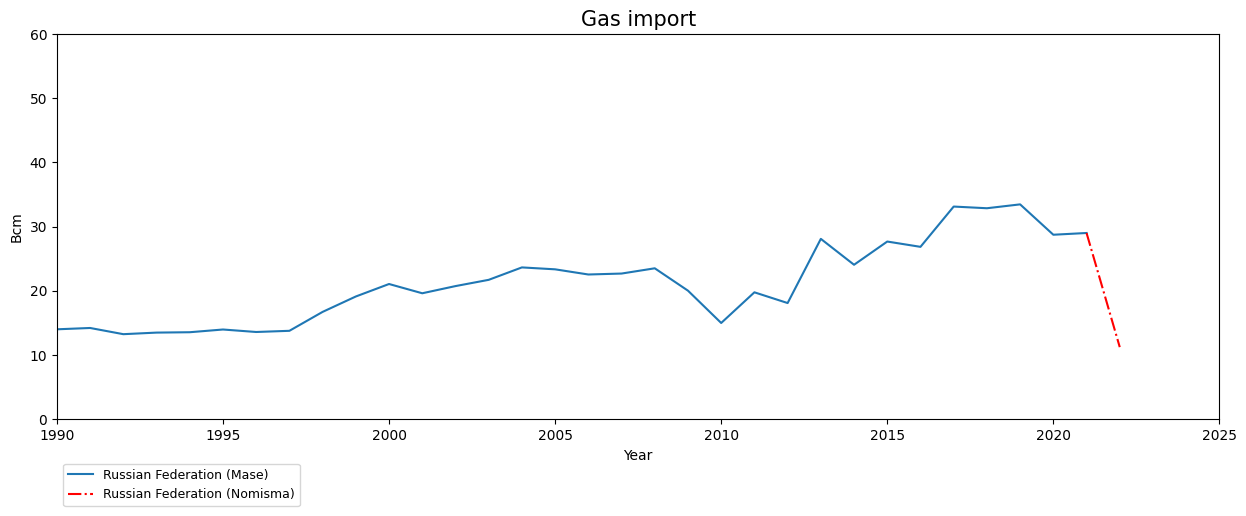

In [28]:
russian_gas_import_to_2021 = gas_import_data[['Year', 'Russian Federation']]
russian_gas_import_to_2021 = russian_gas_import_to_2021.rename(columns={'Russian Federation': 'Russian Federation (Mase)'})

russian_gas_import_21_22 = pd.DataFrame(gas_import_data[gas_import_data['Year']==2021][['Year', 'Russian Federation']])
russian_gas_import_21_22 = russian_gas_import_21_22.rename(columns={'Russian Federation': 'Russian Federation (Nomisma)'})
russian_gas_import_21_22 = russian_gas_import_21_22.append({'Year': 2022, 'Russian Federation (Nomisma)': 11.2}, ignore_index=True)

fig, ax = plt.subplots(figsize=(15, 5))
ax.set_title('Gas import', fontsize=15)
ax.set_ylabel('Bcm')
ax.set_xlabel('Year')

russian_gas_import_to_2021.plot.line(ax=ax, x='Year', linestyle='-')
russian_gas_import_21_22.plot.line(ax=ax, x='Year', linestyle='-.', color={'Russian Federation (Nomisma)': 'red'})

ax.legend(fontsize=9, loc='upper left', bbox_to_anchor=(0.0, -0.1))
plt.xlim((1990, 2025))
plt.ylim((0, 60))

plt.show()

## Conclusions

In this work, the current energy situation in Italy and related future scenarios have been considered and analyzed, starting from the PNIEC 2023 plan presented by the italian government.

Energy sustainability from an environmental point of view is one of the main issues addressed in this plan. The renewable energy targets set for Italy in the nearest future are mostly aligned with the related European Union directives, and aim at marking a turning point for the ecological transition in the country after several years of stagnation. In order to hit the EU target of climate neutrality within 2050, however, more efforts will be required in the next decades, as shown by our projections up to this date.

Regarding the energy security dimension, the Ukraine war has put in evidence the threats that may arise from the strong dependency of the italian energy system from foreign countries' importations. However, a relatively rapid reorganization of the country's energy resources has been put in place and independence from russian gas imports is likely to be achieved within 2025.

## Sources

- https://ourworldindata.org/energy/country/italy
- https://www.mase.gov.it/sites/default/files/PNIEC_2023.pdf
- https://dgsaie.mise.gov.it/gas_naturale_importazioni.php
- https://www.ilsole24ore.com/art/gas-2022-forniture-russia-scese-61percento-AElqjZYC